In [2]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [4]:
def model(t_u, w, b):
    return w * t_u + b

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [8]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [9]:
delta = 0.1

# 重み w に関する損失関数の勾配を有限差分法（中心差分）で数値的に近似
loss_rate_of_change_w = (
    loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)
) / (2.0 * delta)

In [10]:
learning_rate = 1e-2

# 数値微分で得られた勾配に基づき、重み w を勾配降下法で更新
w = w - learning_rate * loss_rate_of_change_w

In [11]:
# バイアス b に関する損失の勾配を有限差分で近似
loss_rate_of_change_b = (
    loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)
) / (2.0 * delta)

# 勾配に基づいてバイアス b を勾配降下法で更新
b = b - learning_rate * loss_rate_of_change_b

In [12]:
def dloss_fn(t_p, t_c):
    # MSE損失に対する予測値 t_p の導関数（∂L/∂t_p）を計算
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [13]:
def dmodel_dw(t_u, w, b):
    # 線形モデル y = w * t_u + b における w に関する偏微分（∂y/∂w）を返す
    return t_u

In [14]:
def dmodel_db(t_u, w, b):
    # 線形モデル y = w * t_u + b における b に関する偏微分（∂y/∂b）は常に 1
    return 1.0

In [15]:
def grad_fn(t_u, t_c, t_p, w, b):
    # 損失関数（MSE）の予測値に関する導関数を取得（∂L/∂t_p）
    dloss_dtp = dloss_fn(t_p, t_c)

    # 連鎖律により ∂L/∂w = ∂L/∂t_p × ∂t_p/∂w
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)

    # 同様に ∂L/∂b = ∂L/∂t_p × ∂t_p/∂b
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)

    # バッチ全体の勾配を合計して、wとbの勾配ベクトルとして返す
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    # エポック数に応じて学習を繰り返す
    for epoch in range(1, n_epochs + 1):
        w, b = params  # 現在のパラメータを展開（重みとバイアス）

        # 予測値を計算：モデル出力 y_hat = w * t_u + b
        t_p = model(t_u, w, b)  # <1>

        # 平均二乗誤差に基づく損失を計算
        loss = loss_fn(t_p, t_c)

        # 損失に基づく勾配を計算（∂L/∂w, ∂L/∂b）
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        # 計算された勾配の中身とその形状を出力（デバッグ用）
        print(grad)
        print(grad.shape)

        # パラメータを勾配方向に更新（勾配降下法）
        params = params - learning_rate * grad

        # 各エポックの損失を表示
        print("Epoch %d, Loss %f" % (epoch, float(loss)))  # <3>

    # 最終的に学習されたパラメータを返す
    return params

In [17]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    # エポック数（学習反復回数）に従ってループ
    for epoch in range(1, n_epochs + 1):
        # パラメータ（重みとバイアス）を展開
        w, b = params

        # 順伝播により予測値を算出（モデル：y = wt_u + b）
        t_p = model(t_u, w, b)

        # 損失（MSE）を算出
        loss = loss_fn(t_p, t_c)

        # 勾配（∂Loss/∂w, ∂Loss/∂b）を計算
        grad = grad_fn(t_u, t_c, t_p, w, b)

        # パラメータの更新（勾配降下法）
        params = params - learning_rate * grad

        # 特定のエポックでのみログを出力（省略出力で可読性向上）
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print("Epoch %d, Loss %f" % (epoch, float(loss)))
            if print_params:
                print("    Params:", params)
                print("    Grad:  ", grad)

        # ログ出力を省略するエポックを明示
        if epoch in {4, 12, 101}:
            print("...")

        # NaNやInfが損失に出たら学習中止（数値安定性の確保）  # <3>
        if not torch.isfinite(loss).all():
            break

    # 最終的な学習済みパラメータを返す
    return params

In [18]:
training_loop(
    n_epochs=100, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c
)

Epoch 1, Loss 1763.884644
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9707])
Epoch 3, Loss 19408033792.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901124996059702376382357942829056.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [19]:
training_loop(
    n_epochs=100, learning_rate=1e-4, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c
)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5492,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [20]:
t_un = 0.1 * t_u

In [21]:
training_loop(
    n_epochs=100,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u=t_un,
    t_c=t_c,
)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148712
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [22]:
params = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u=t_un,
    t_c=t_c,
    print_params=False,
)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148712
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012])

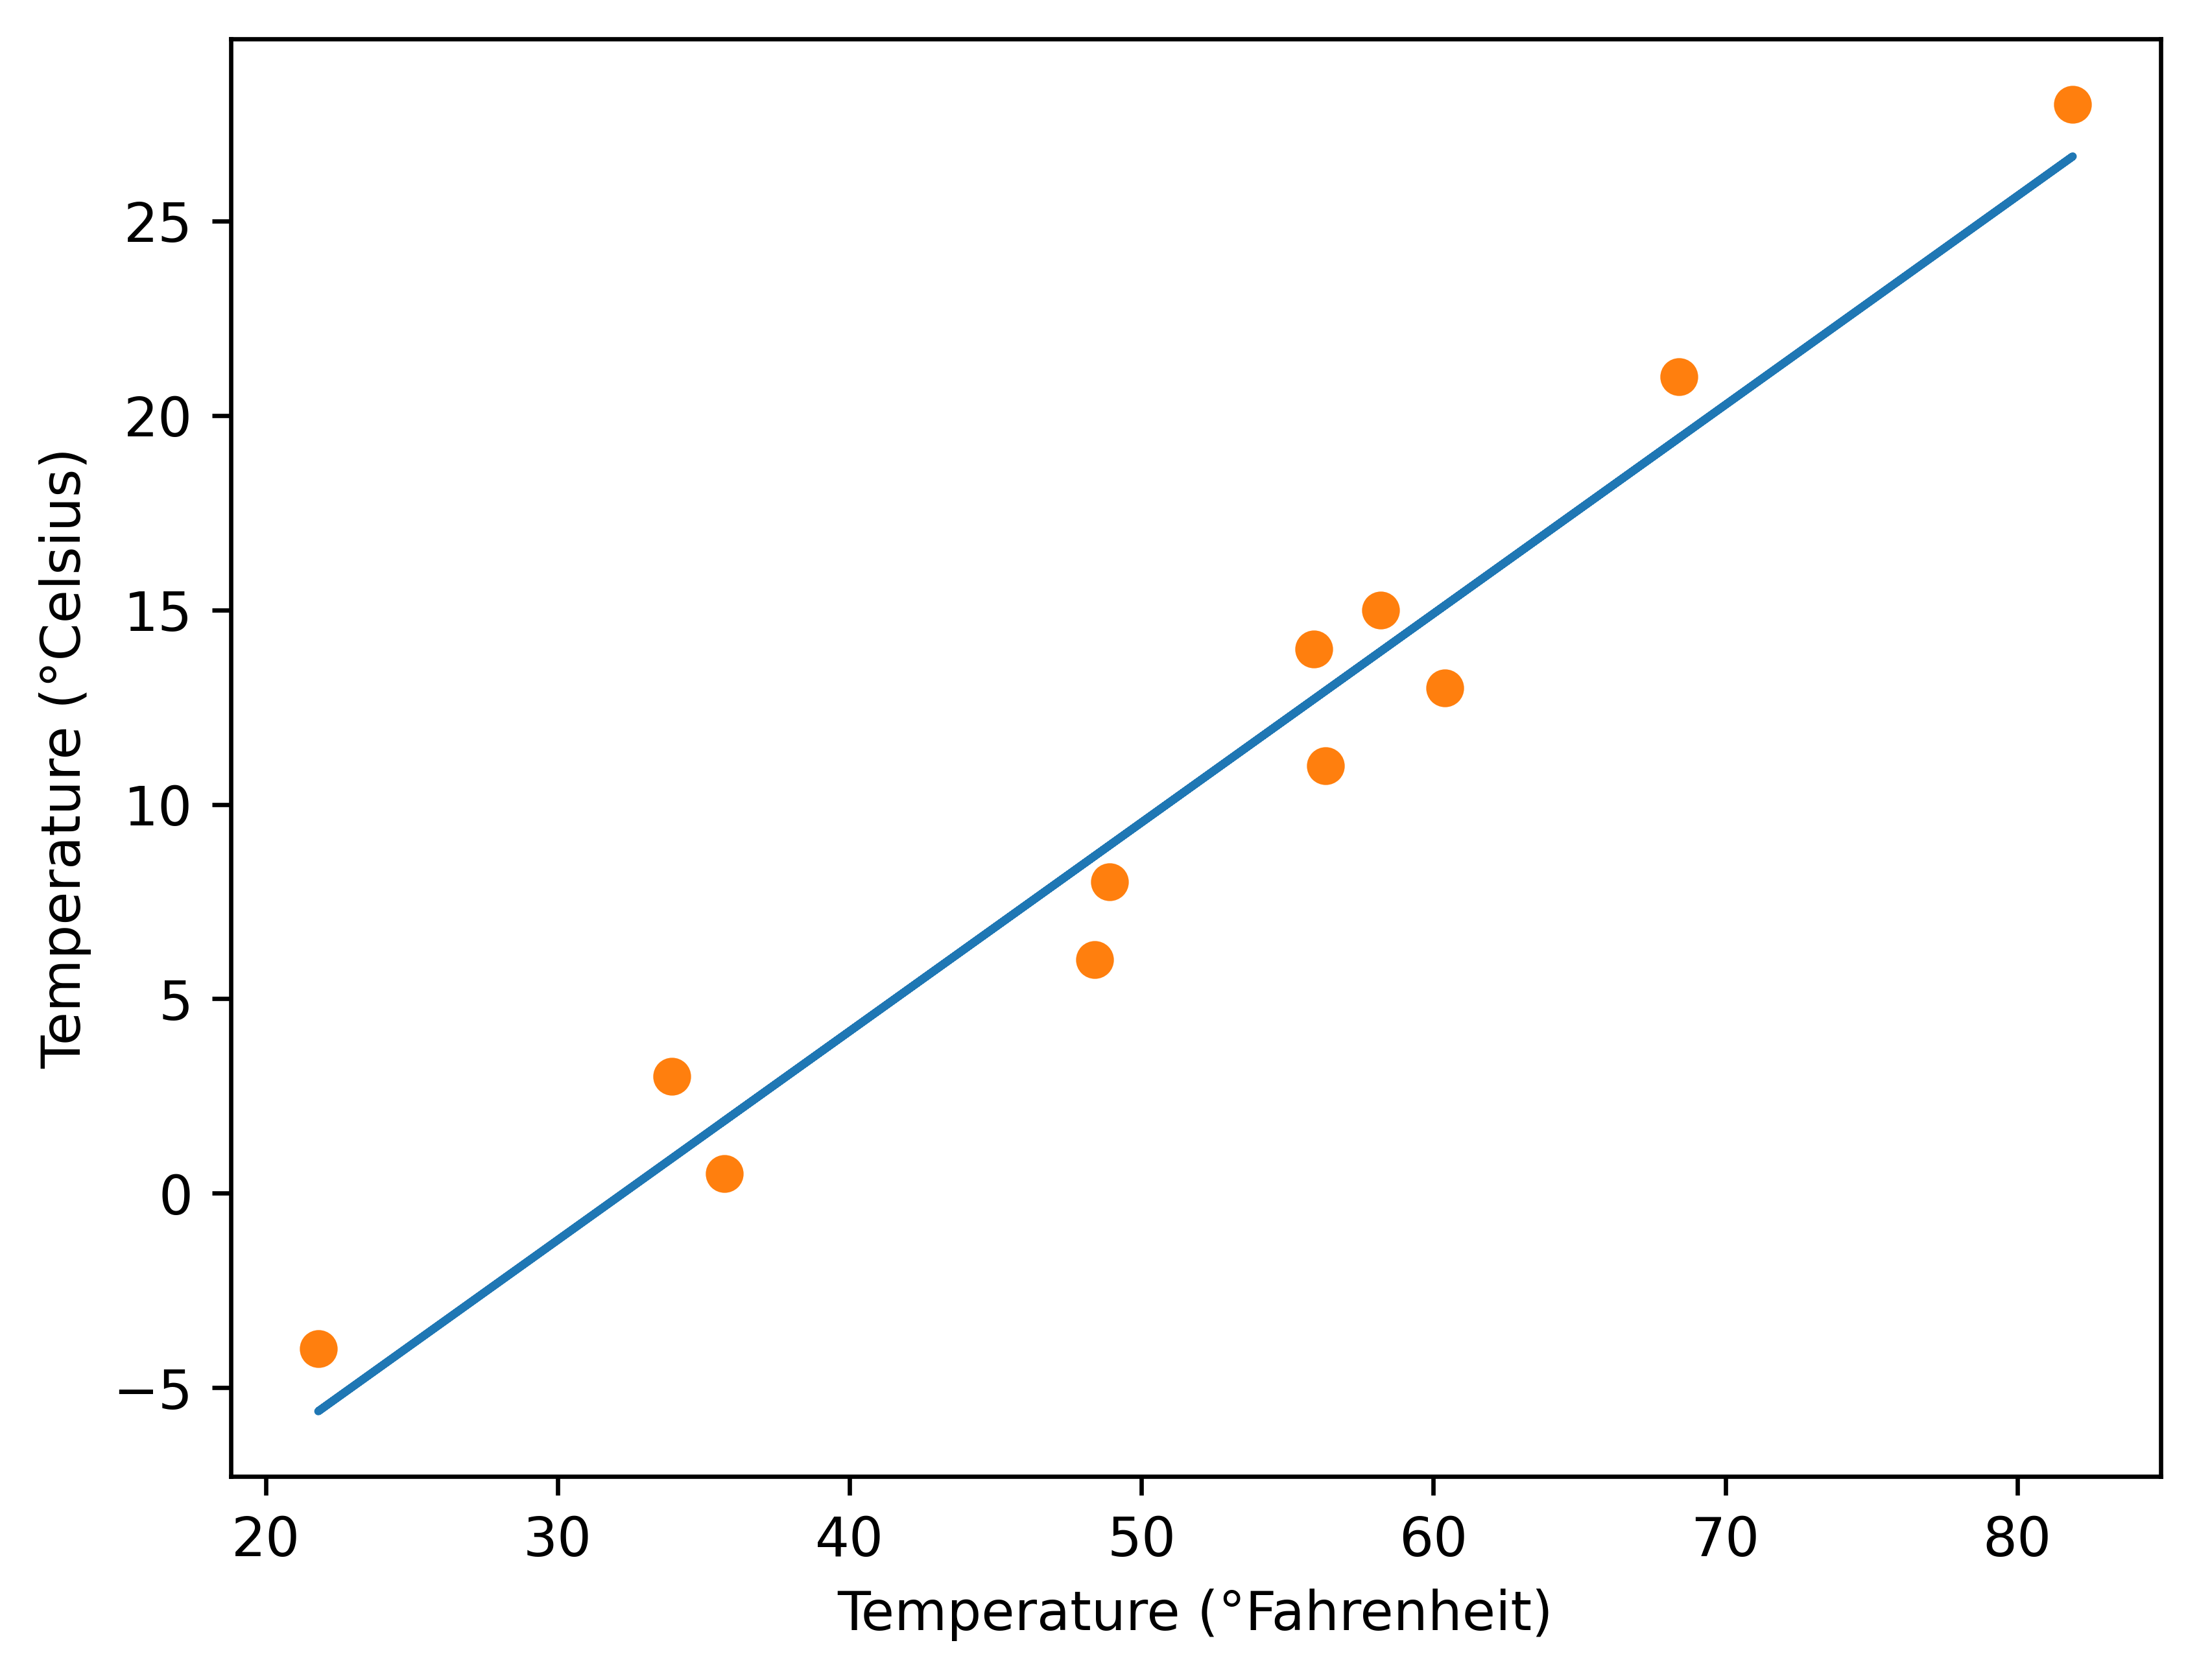

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# plt.savefig("temp_unknown_plot.png", format="png")  # bookskip